In [46]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
import torch as t
import numpy as np
import matplotlib.pyplot as plt

from transformers import GPT2TokenizerFast
from transformers.models.gpt2.tokenization_gpt2_fast import GPT2TokenizerFast

from gpt import GPT2, load_weights
from hook_handler import HookHandler

In [48]:
gpt = load_weights(GPT2)
gpt.eval();
tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')

In [49]:
def most_likely(model_out, k=5):
    target_probs = t.softmax(model_out.logits.squeeze(0), dim=0)
    top_probs, top_ids = t.topk(target_probs, k=k)
    for i in range(k):
        token = tokenizer.decode(top_ids[i])
        print(f"{repr(token).ljust(15)}{top_probs[i]:.2%}")

with HookHandler() as hh:
    for i, block in enumerate(gpt.blocks):
        hh.add_save_activation_hook(block, key=i)

    input_ids = tokenizer.encode("The Eiffel Tower is located in the city of", return_tensors="pt")
    out = gpt(input_ids)
    activations = hh.activations

    print("Baseline completions")
    most_likely(gpt(input_ids))

Baseline completions
' Paris'       6.37%
' London'      4.61%
' Amsterdam'   3.41%
' New'         3.18%
' Berlin'      2.61%


In [50]:
tokenizer.encode("Paris")

[40313]

In [83]:
def get_correct_prob(out, correct_id):
    return t.softmax(out.logits[0], dim=-1)[correct_id].item()


def print_tokenized(ids):
    l = tokenizer.batch_decode([[id] for id in ids])
    for t in l:
        print(repr(t), end=" ")
    print()


def run_baseline(model, input_ids, correct_id):
    with HookHandler() as hh:
        for i, block in enumerate(model.blocks):
            hh.add_save_activation_hook(block, key=i)

        logits = model(input_ids)
        correct_prob = get_correct_prob(logits, correct_id)
        return hh.activations, correct_prob

def avg_evaluate(model, input_ids, correct_id, k=5, **kwargs):
    probs = []
    seeds = range(k)
    for seed in seeds:
        t.manual_seed(seed)
        corrupt_out = model.forward_corrupt_and_patch(
            input_ids, **kwargs
        )
        probs.append(get_correct_prob(corrupt_out, correct_id))
    return sum(probs)/k

def patching(model: GPT2, tokenizer, subject, relation, target):
    subject_ids = tokenizer.encode(subject, return_tensors="pt")
    relation_ids = tokenizer.encode(relation, return_tensors="pt")
    subj_len = subject_ids.shape[1]
    input_ids = t.cat((subject_ids, relation_ids), dim=1)
    print_tokenized(input_ids[0])
    correct_id = tokenizer.encode(target)
    assert len(correct_id) == 1
    correct_id = correct_id[0]

    activations, p_baseline = run_baseline(model, input_ids, correct_id)

    print(p_baseline)

    n_layers = len(model.blocks)
    n_tokens = input_ids.shape[1]
    avg_prob = np.zeros((n_tokens, n_layers))
    for patch_token in range(n_tokens):
        for layer in range(n_layers):
            patch_value = activations[layer][0, patch_token]
            prob = avg_evaluate(
                model, input_ids=input_ids, correct_id=correct_id, k=3,
                patch=True, patch_layer=layer, patch_value=patch_value, patch_id=patch_token,
                corrupt=True, corrupt_up_to=subj_len, corrupt_noise_std=.1
            )
            avg_prob[patch_token, layer] = prob
    return avg_prob

probs = patching(gpt, tokenizer, "The Eiffel Tower", "is located in the city of", " Paris")

'The' ' E' 'iff' 'el' ' Tower' 'is' ' located' ' in' ' the' ' city' ' of' 
0.04820826277136803


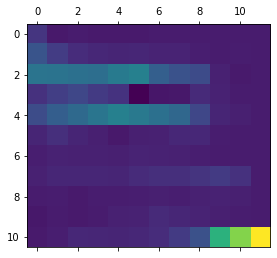

In [84]:
plt.matshow(probs)

In [85]:
probs

array([[0.02436324, 0.0219464 , 0.02216303, 0.02210568, 0.02213864,
        0.02211011, 0.02217013, 0.02220609, 0.0222077 , 0.02221264,
        0.02217421, 0.02217815],
       [0.02742387, 0.02511661, 0.02366233, 0.02321812, 0.0229683 ,
        0.02304354, 0.02290683, 0.02285297, 0.0224273 , 0.02226189,
        0.02227878, 0.02217815],
       [0.03092285, 0.03076629, 0.03049103, 0.03024837, 0.03166145,
        0.03233708, 0.02862963, 0.02714776, 0.02644857, 0.02268049,
        0.0220969 , 0.02217815],
       [0.02403027, 0.02531252, 0.02601109, 0.02486087, 0.02420756,
        0.02007296, 0.02181539, 0.02190646, 0.02340199, 0.02274748,
        0.02226583, 0.02217815],
       [0.02661828, 0.02848907, 0.02964423, 0.03104737, 0.03228635,
        0.03143164, 0.03041397, 0.02951983, 0.0261109 , 0.02301843,
        0.02249195, 0.02217815],
       [0.02296451, 0.02386267, 0.02299169, 0.0225172 , 0.02199822,
        0.02252349, 0.02271045, 0.02320788, 0.0231623 , 0.02232462,
        0.02219917,

In [ ]:
print("Zeroed out 'theory' token")
for i in range(12):
    print(f"on layer {i}")
    most_likely(gpt.forward_patched_activation(input_ids, 3, i, t.zeros(768)), k=2)
